In [3]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [4]:
two_composite_filtered = pd.read_csv("../Curated_data/two_composite_filtered.csv", low_memory=False)


In [5]:

variable = 'Density_gcm3'
covariates = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
hole = 'KV139'

#Select columns of interest
selected_columns = ["Name", 'X', 'Y', 'Z', variable] + covariates
two_composite_1covariates = two_composite_filtered[selected_columns]

#Drop NA's and filter for the chosen hole
two_composite_1covariates = two_composite_1covariates.dropna(subset=[variable] + covariates)
two_composite_1covariates_1hole = two_composite_1covariates.loc[two_composite_1covariates['Name'] == hole]

In [6]:

encoded_data = two_composite_1covariates_1hole.copy()

threshold = 10

for column in two_composite_1covariates_1hole.columns:
    if two_composite_1covariates_1hole[column].dtype == 'object':
        unique_values = two_composite_1covariates_1hole[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])



In [7]:
# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )



In [8]:
# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [9]:
two_composite_1covariates_1hole = encoded_data[["X", "Y", "Z", "Density_gcm3"] + total_columns]
covariates = total_columns

In [15]:
covariates

['CP_Total', 'PO_Total']

C:\Users\flea0265\AppData\Local\Temp\ipykernel_8752\1919043354.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\flea0265\AppData\Local\Temp\ipykernel_8752\1919043354.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\flea0265\AppData\Local\Temp\ipykernel_8752\1919043354.py:58: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\fle

- Iteration 0, MSE: 0.590
- Iteration 1000, MSE: 0.015


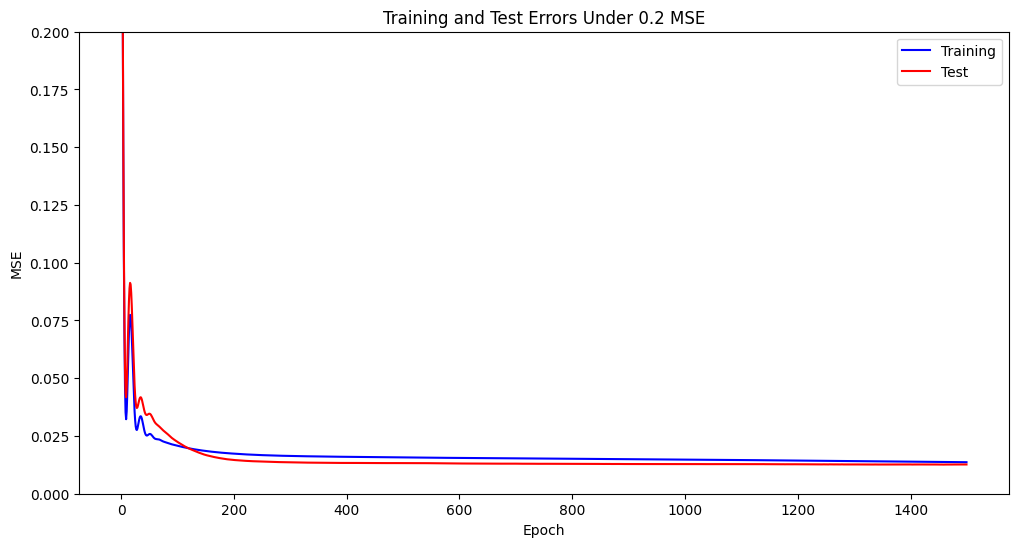

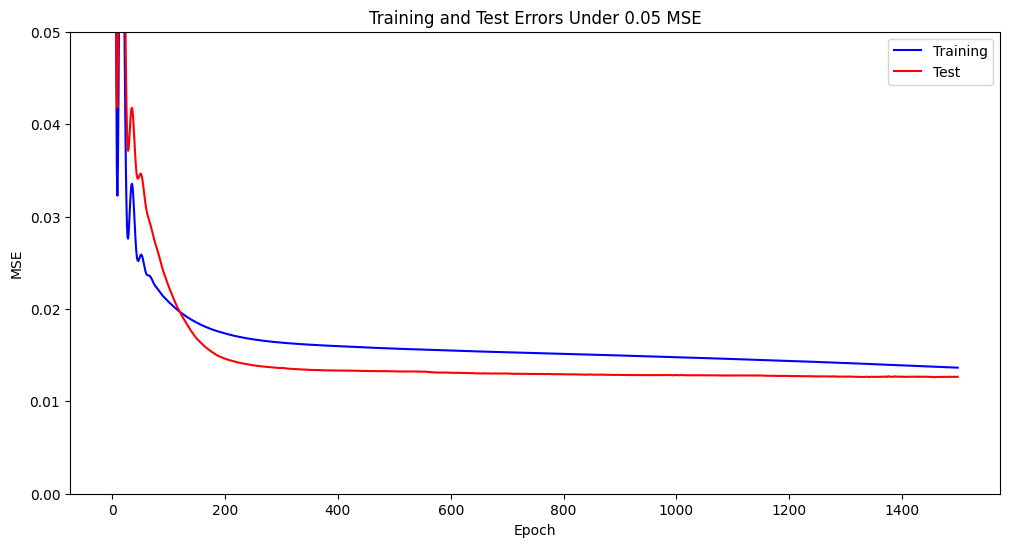

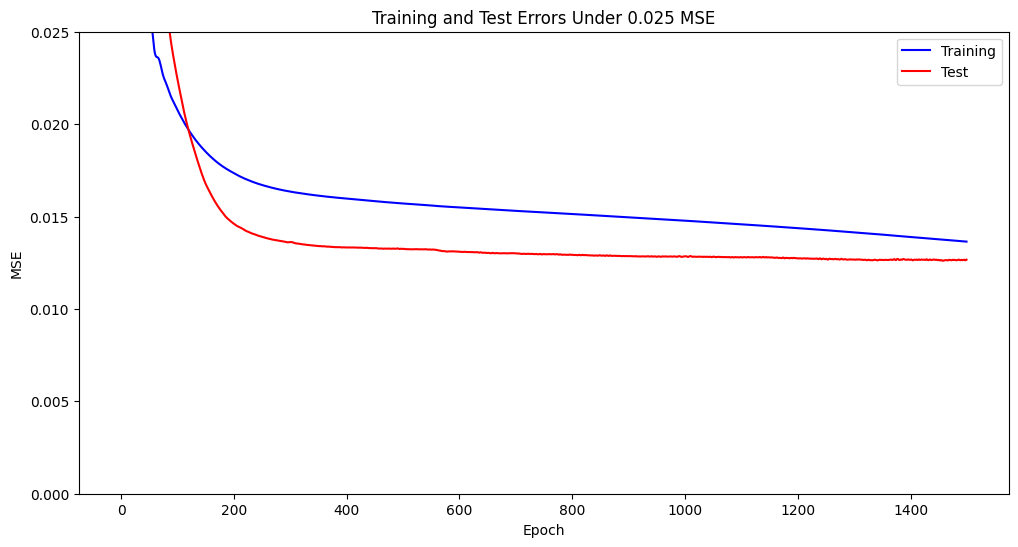

In [18]:
np.random.seed(42)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = two_composite_1covariates_1hole[columns_to_normalize].min()

for column in columns_to_normalize:
    two_composite_1covariates_1hole[column] = two_composite_1covariates_1hole[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = two_composite_1covariates_1hole[columns_to_normalize].min().min()
max_values = two_composite_1covariates_1hole[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    two_composite_1covariates_1hole[column] = (two_composite_1covariates_1hole[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
two_composite_1covariates_1hole.loc[:, [variable]+covariates] = scaler.fit_transform(two_composite_1covariates_1hole.loc[:, [variable]+covariates])

x = two_composite_1covariates_1hole[['X','Y', 'Z'] + covariates].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = two_composite_1covariates_1hole[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(two_composite_1covariates_1hole),5)
x = x[:,[0,1,2,3,4]]

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]



import matplotlib.pyplot as plt

# Create train and test sets
x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

model = nn.Sequential(
    nn.Linear(in_features=5, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(1500):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()

# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()



# # Define a grid of points for prediction (including X, Y, and Z)
# x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 60)
# y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 6)
# z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 100)
# xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# # Make predictions for the grid
# predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# # Reshape the predictions to match the grid shape
# predictions = predictions.data.numpy().reshape(60, 6, 100)

# pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# # Determine the minimum and maximum values for the color mapping
# vmin = np.min(pooled_values)
# vmax = np.max(pooled_values)


# fig = go.Figure(data=[
#     go.Scatter3d(
#     x=xyz_grid[:,0],
#     y=xyz_grid[:,1],
#     z=xyz_grid[:,2],
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=predictions.ravel(),
#         colorscale='BrBG_r',  # Adjust the color scale
#         colorbar=dict(title=variable),
#         opacity=0.7,
#         cmax=vmax,
#         cmin=vmin,
#     ),
#     name='Preds',
#     text = ["Density: {}".format(x) for x in predictions.ravel() ]
# )])


# # Add a scatter plot for data points
# fig.add_trace(go.Scatter3d(
#     x=x.data.numpy()[:, 0],
#     y=x.data.numpy()[:, 1],
#     z=x.data.numpy()[:, 2],
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=y.data.numpy().ravel(),
#         colorscale='BrBG_r',  # Adjust the color scale
#         colorbar=dict(title=variable),
#         opacity=0.7,
#         cmax=vmax,
#         cmin=vmin,
#     ),
#     name='Test set',
#     text = ["Density: {}".format(x) for x in y.data.numpy().ravel()]

# ))




# fig.update_layout(
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z',
#         aspectmode='data',
#     ),
# )
# fig.write_html('tmp.html', auto_open=True)
# #fig.show()




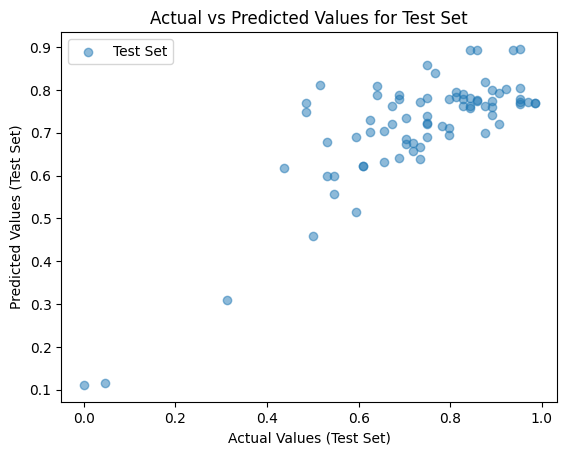

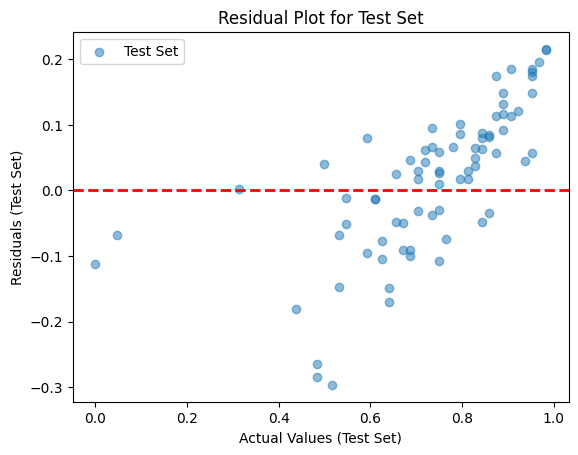

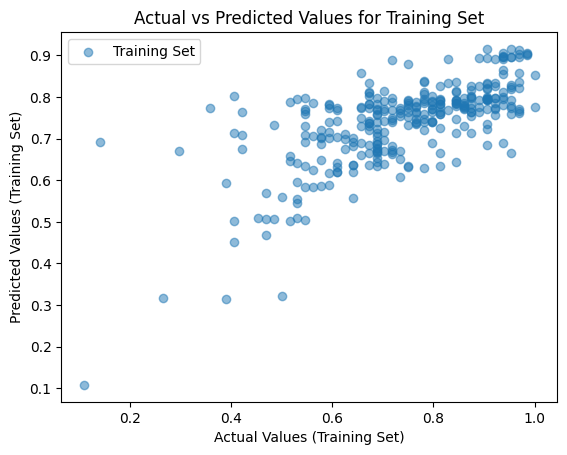

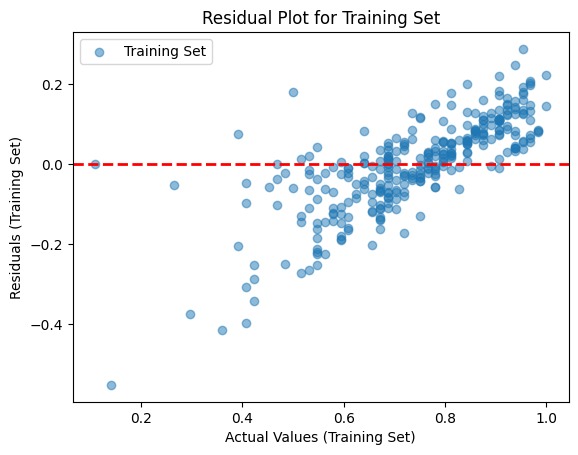

Metrics for Test set:
  MSE: 0.0127
  RMSE: 0.1125
  MAE: 0.0911
  R^2: 0.6337

Metrics for Training set:
  MSE: 0.0136
  RMSE: 0.1168
  MAE: 0.0880
  R^2: 0.4657



In [19]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()

# Plot actual vs predicted values for the test set
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Test Set')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs Predicted Values for Test Set')
plt.legend()
plt.show()

# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5, label='Training Set')
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Predicted Values (Training Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.legend()
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")

